In [3]:
import torch
import pandas as pd
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

from torch import nn
from torch import optim

import torch.nn.functional as F
import scipy
from sklearn.utils import resample
from collections import OrderedDict

In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, images_path):
        self.dataframe = dataframe
        self.images_path = images_path

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
#         print(row['index'])
        img = Image.open(self.images_path + str(int(row['index'])).zfill(4) + '.jpg')
#         img = img.resize((224,224), Image.ANTIALIAS)
        return (
            torchvision.transforms.functional.to_tensor(img),
            row["data"],
        )


In [5]:
df = pd.read_csv('train_steer.csv', index_col=False)
df = df.reset_index()


<AxesSubplot:ylabel='Frequency'>

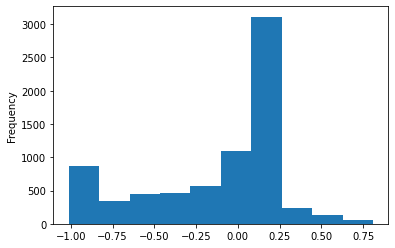

In [6]:
# image, label = next(iter(test_dataset))
df.data.plot.hist()

,index,Unnamed: 0,data
0,0,0,0.0875
1,1,1,0.0900
2,2,2,0.0900
3,3,3,0.0875
4,4,4,0.0875
...,...,...,...
1560,1560,1560,-0.4400
1995,1995,1995,-0.8375
3558,3558,3558,-0.5175
1639,1639,1639,-0.9800


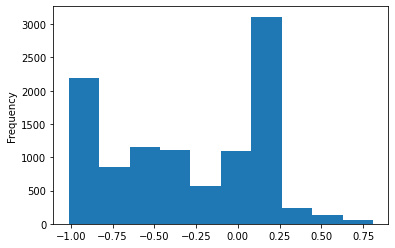

In [48]:
# plt.imshow(image.permute(1, 2, 0))
threshold = -0.3
df_min = df[df.data < threshold]
df_maj = df[df.data >= threshold]

df_minority_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_maj),    # to match majority class
                                 random_state=123)
# df
df_balanced = pd.concat([df_maj, df_minority_upsampled])
df_balanced.data.plot.hist()

df_balanced
# train_df['data'].plot.hist()

In [46]:
dataset = Dataset(df, '../../../../catkin_ws/images/train/left')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [8]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [9]:
for param in model.parameters():
    param.requires_grad = False 

In [23]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(128,64)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(64,1)),
    ('out', nn.Tanh())
])).to(device)

model.fc = fc

In [24]:
model = model.to(device);

image, l = next(iter(dataloader))

Epoch : 1/10.. Training Loss: 0.147315
Epoch : 2/10.. Training Loss: 0.137317
Epoch : 3/10.. Training Loss: 0.131215
Epoch : 4/10.. Training Loss: 0.130871
Epoch : 5/10.. Training Loss: 0.126965
Epoch : 6/10.. Training Loss: 0.126356
Epoch : 7/10.. Training Loss: 0.124689
Epoch : 8/10.. Training Loss: 0.121290
Epoch : 9/10.. Training Loss: 0.120189
Epoch : 10/10.. Training Loss: 0.116532


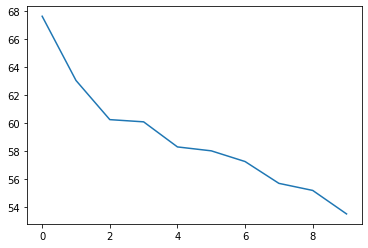

In [25]:
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss =[]
    for e in range(epochs):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(inputs)
            target = labels.reshape(out.shape[0],1).float()
            loss = criterion(out, target)
            running_loss+=loss
            loss.backward()
            optimizer.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show() 
    
    
    
epochs = 10
model.train()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.MSELoss()  
train(model,dataloader,criterion, optimizer, epochs)        

In [58]:
model.eval()
torch.save(model, "unbalanced_model")

In [59]:
model.eval()
img = Image.open('../../../../catkin_ws/images/test/left0000.jpg')
torch_img = torchvision.transforms.functional.to_tensor(img)
print(torch_img)
# imshow(img)
model(torch_img.reshape(1,3,120,320).to(device))

tensor([[[0.0941, 0.0902, 0.0824,  ..., 0.5373, 0.3176, 0.0510],
         [0.0941, 0.0863, 0.1059,  ..., 0.5412, 0.2745, 0.0627],
         [0.0745, 0.0941, 0.0784,  ..., 0.5098, 0.2314, 0.0627],
         ...,
         [0.1490, 0.1569, 0.1569,  ..., 0.1529, 0.1608, 0.1608],
         [0.1490, 0.1569, 0.1569,  ..., 0.1647, 0.1686, 0.1686],
         [0.1490, 0.1608, 0.1569,  ..., 0.1686, 0.1686, 0.1725]],

        [[0.0941, 0.0902, 0.0824,  ..., 0.5373, 0.3176, 0.0510],
         [0.0941, 0.0863, 0.1059,  ..., 0.5412, 0.2745, 0.0627],
         [0.0745, 0.0941, 0.0784,  ..., 0.5098, 0.2314, 0.0627],
         ...,
         [0.1490, 0.1569, 0.1569,  ..., 0.1529, 0.1608, 0.1608],
         [0.1490, 0.1569, 0.1569,  ..., 0.1647, 0.1686, 0.1686],
         [0.1490, 0.1608, 0.1569,  ..., 0.1686, 0.1686, 0.1725]],

        [[0.0941, 0.0902, 0.0824,  ..., 0.5373, 0.3176, 0.0510],
         [0.0941, 0.0863, 0.1059,  ..., 0.5412, 0.2745, 0.0627],
         [0.0745, 0.0941, 0.0784,  ..., 0.5098, 0.2314, 0.

tensor([[-0.1703]], device='cuda:0', grad_fn=<TanhBackward>)